<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Dirac_Equation_with_Memory_Effects_at_Multiple_Times.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_ivp/base.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(fun(t, y), dtype=dtype)


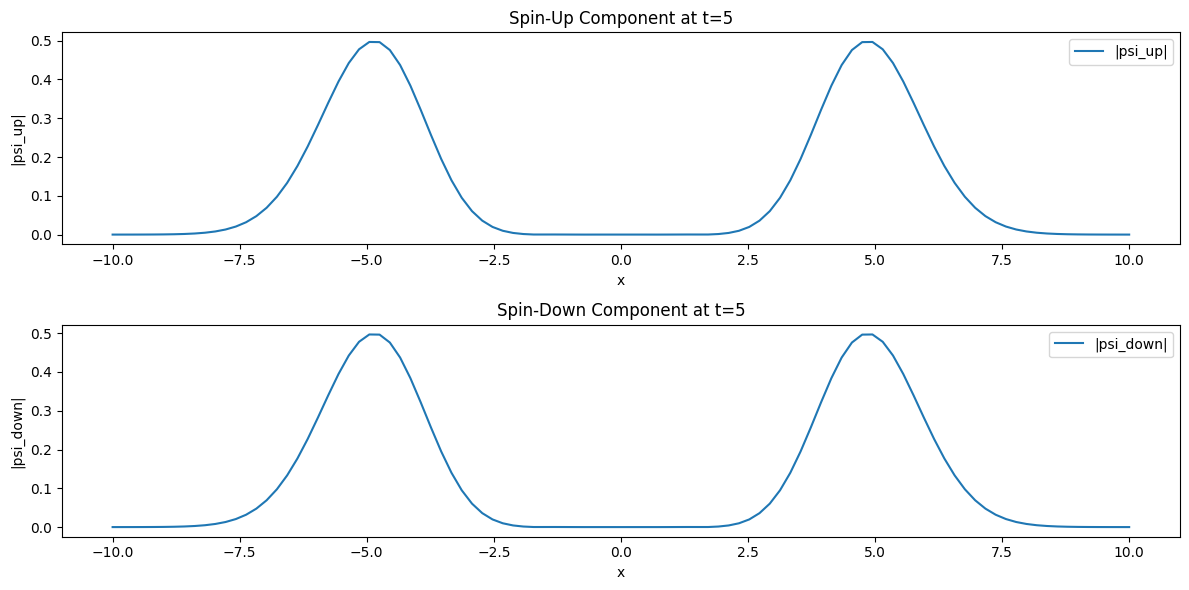

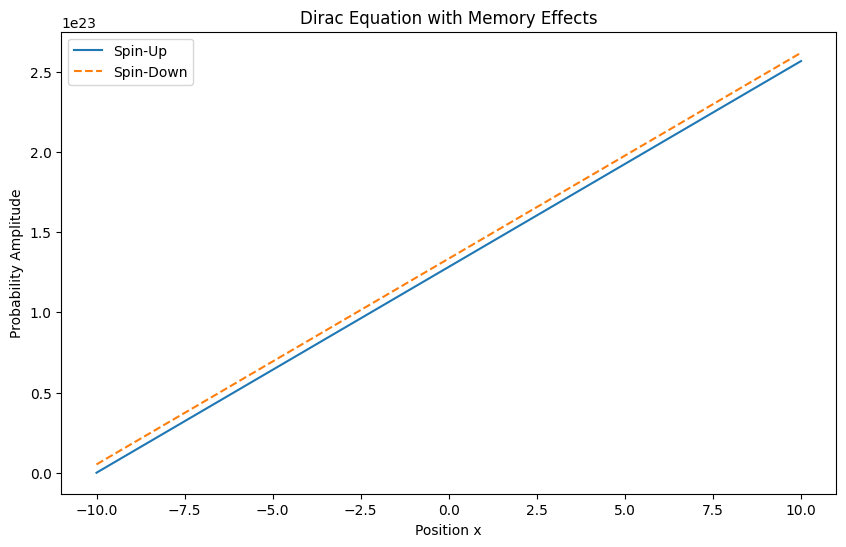

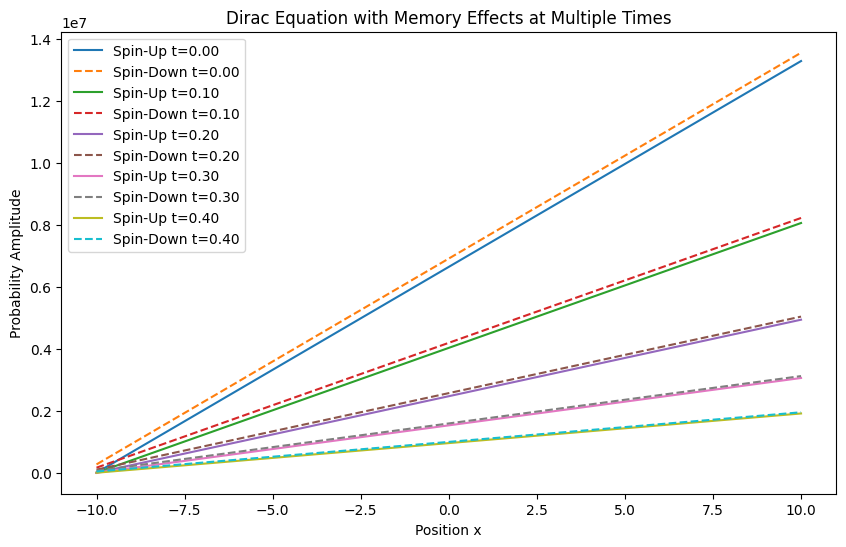

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp

hbar = 1.0  # Set value for hbar
c = 1.0    # Set value for speed of light
m = 1.0    # Set value for mass

# Define Dirac Hamiltonian for 1D
def H(psi, x):
    alpha = np.array([[0, 1], [1, 0]])
    beta = np.array([[1, 0], [0, -1]])
    p_operator = -1j * hbar * np.gradient(psi, x, edge_order=2, axis=1)

    kinetic = np.matmul(alpha, p_operator)
    potential = m * c**2 * np.matmul(beta, psi)

    return kinetic + potential

# Define kernel for memory term
def K(t):
    # Example: exponential decay memory kernel
    return np.exp(-t)

# Buffer to hold psi history
x = np.linspace(-10, 10, 100)
t = np.linspace(0, 10, 100)
#psi_buffer = [np.zeros_like(x) for _ in range(len(t))]
dx = x[1] - x[0]


# Buffer to hold psi history, initialized to zeros
psi_buffer = np.zeros((len(t), len(x)*2))
buffer_idx = 0

def dirac_with_memory(t, psi_1D, x, dt):
    global buffer_idx

    # Reshape psi from 1D to its original 2D shape
    psi = psi_1D.reshape(2, -1)

    # Store current psi in buffer and update index
    psi_buffer[buffer_idx] = psi_1D.ravel()

    buffer_idx = (buffer_idx + 1) % len(psi_buffer)

    # Memory term (discretized convolution)
    times = np.arange(buffer_idx) * dt
    memory = K(times[:, None]) * psi_buffer[:buffer_idx]
    memory_term = dt * np.sum(memory, axis=0).reshape(2, -1)

    # Dirac equation
    dpsi = 1j / hbar * (H(psi, x) - memory_term)

    return dpsi.ravel()

# Solve differential equation with complex128 dtype
x = np.linspace(-10, 10, 100)

# Set up time grid
t = np.linspace(0, 10, 100)
dt = t[1] - t[0]

psi_0_up = np.exp(-0.5 * x**2)  # Gaussian wave packet for spin-up
psi_0_down = np.zeros_like(x)  # Spin-down component is zero
psi_0 = np.vstack([psi_0_up, psi_0_down]).ravel()

# Solve the differential equation again
solution = solve_ivp(dirac_with_memory, (t[0], t[-1]), psi_0, t_eval=t, args=(x, dt))

psi_solution_2D = solution.y.reshape(2, len(x), -1)

import matplotlib.pyplot as plt

# Choose a specific time point for visualization, e.g., t=5
index_t5 = np.argmin(np.abs(solution.t - 5))

# Plot
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(x, np.abs(psi_solution_2D[0, :, index_t5]), label='|psi_up|')
plt.title('Spin-Up Component at t=5')
plt.xlabel('x')
plt.ylabel('|psi_up|')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x, np.abs(psi_solution_2D[1, :, index_t5]), label='|psi_down|')
plt.title('Spin-Down Component at t=5')
plt.xlabel('x')
plt.ylabel('|psi_down|')
plt.legend()

plt.tight_layout()
plt.show()

solution = solve_ivp(dirac_with_memory, (t[0], t[-1]), psi_0, t_eval=t, args=(x, dt), method='RK45', rtol=1e-6, atol=1e-6, vectorized=True, first_step=dt)

# Extract solution
psi_solution = solution.y

###############################################

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants
hbar = 1.0
c = 1.0
m = 1.0

# Finite difference for gradient
def gradient(f, dx):
    df = np.zeros_like(f)
    df[:-1] = (f[1:] - f[:-1]) / dx
    df[-1] = (f[-1] - f[-2]) / dx
    return df

# Hamiltonian
def H(psi, x, dx):
    alpha = np.array([[0, 1], [1, 0]])
    beta = np.array([[1, 0], [0, -1]])
    p_operator = -1j * hbar * gradient(psi, dx)

    kinetic_up = alpha[0, 0] * p_operator[0] + alpha[0, 1] * p_operator[1]
    kinetic_down = alpha[1, 0] * p_operator[0] + alpha[1, 1] * p_operator[1]

    potential_up = beta[0, 0] * m * c**2 * psi[0] + beta[0, 1] * m * c**2 * psi[1]
    potential_down = beta[1, 0] * m * c**2 * psi[0] + beta[1, 1] * m * c**2 * psi[1]

    return np.array([kinetic_up + potential_up, kinetic_down + potential_down])

# Memory kernel
def K(t):
    return np.exp(-t)

# Memory kernel
#def K(t):
#    return 0.0


# Buffer for psi
psi_buffer = []

# Dirac equation with memory
def dirac_with_memory(t, psi_1D, x, dt, buffer_length):
    psi = psi_1D.reshape(2, -1)

    if len(psi_buffer) >= buffer_length:
        psi_buffer.pop(0)
    psi_buffer.append(psi)

    times = np.arange(len(psi_buffer)) * dt
    memory_term = dt * np.sum(K(times[:, None, None]) * np.array(psi_buffer), axis=0)

    dpsi = 1j / hbar * (H(psi, x, dx) - memory_term)

    return dpsi.ravel()

# Spatial grid and initial condition
x = np.linspace(-10, 10, 100)
dx = x[1] - x[0]
psi_0_up = np.exp(-0.5 * x**2)
#psi_0_down = np.zeros_like(x)
psi_0_down = np.exp(0.5 * x**2)

psi_0 = np.vstack([psi_0_up, psi_0_down]).ravel()

# Time grid
t = np.linspace(0, 10, 100)
dt = t[1] - t[0]
buffer_length = len(t)

# Solve the differential equation
solution = solve_ivp(dirac_with_memory, (t[0], t[-1]), psi_0, t_eval=t, args=(x, dt, buffer_length))

# Extract and plot solution
psi_solution = solution.y.reshape(2, -1, len(x))
plt.figure(figsize=(10, 6))
plt.plot(x, np.abs(psi_solution[0, -1, :]), label="Spin-Up")
plt.plot(x, np.abs(psi_solution[1, -1, :]), label="Spin-Down", linestyle="--")
plt.xlabel('Position x')
plt.ylabel('Probability Amplitude')
plt.legend()
plt.title('Dirac Equation with Memory Effects')
plt.show()

# ... [rest of the code remains unchanged]

# Modify initial condition to a narrower Gaussian centered at x=0
psi_0_up = np.exp(-0.5 * (x/2)**2)  # Narrower Gaussian
#psi_0_down = np.zeros_like(x)
psi_0_down = np.exp(0.5 * (x/2)**2)
psi_0 = np.vstack([psi_0_up, psi_0_down]).ravel()

# Solve the differential equation
solution = solve_ivp(dirac_with_memory, (t[0], t[-1]), psi_0, t_eval=t, args=(x, dt, buffer_length))

# Extract and plot solution at multiple time points
psi_solution = solution.y.reshape(2, -1, len(x))
plt.figure(figsize=(10, 6))

for i, time in enumerate([0, 25, 50, 75, 99]):
    plt.plot(x, np.abs(psi_solution[0, i, :]), label=f"Spin-Up t={t[i]:.2f}")
    plt.plot(x, np.abs(psi_solution[1, i, :]), label=f"Spin-Down t={t[i]:.2f}", linestyle="--")

plt.xlabel('Position x')
plt.ylabel('Probability Amplitude')
plt.legend()
plt.title('Dirac Equation with Memory Effects at Multiple Times')
plt.show()

